# Lacuna AI4EA Workshop

In this notebook, we will walk through how we used earth observation data and machine learning methods to estimate appliance ownership in Sub-Saharan Africa.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
content_path = '/content/drive/MyDrive/Lacuna-AI4EA/WorkshopData'

print(os.listdir(content_path))
os.chdir(content_path)

['geoBoundaries-NGA-ADM2.geojson', 'labels_t.csv', 'ent_labels.csv', 'geo_data.geojson', 'nigeria_reduced_features.geojson', 'lga_features.geojson', 'lga_num_hh.csv', 'lga_full_features.geojson', 'nigeria_full_features.geojson', 'appliance_labels.csv']


# Data Setup


In [ ]:
# @title Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import geopandas as gpd
import seaborn as sns
from matplotlib.patches import Patch
import math

import warnings
warnings.filterwarnings('ignore')


In [ ]:
#@title Load in Features

fts = gpd.read_file("nigeria_full_features.geojson")

fts.head(10)

,hhid,tot_population,med_temperature,med_precipitation,med_awi,med_spending,BUI_percentile_5,BUI_percentile_25,BUI_median,BUI_percentile_75,...,electrification_prop_04,electrification_prop_05,electrification_prop_06,electrification_prop_07,electrification_prop_08,electrification_prop_09,electrification_prop_10,electrification_prop_11,electrification_prop_12,geometry
0,d8af8ab5-30ab-4d9f-bfe4-81231dbe5dbf,7444.804199,301.977478,0.001807,0.271148,2.729253,0.0,0.0,0.0,0.0,...,0.17226535704699322,0.17226535704699322,0.17226535704699322,0.17226535704699322,0.17226535704699322,0.17226535704699322,0.17226535704699322,0.17226535704699322,0.17226535704699322,"POLYGON ((4.98125 9.46733, 4.98117 9.4656, 4.9..."
1,e8245d5c-8130-4e78-b4b0-1053b7ecbc9b,7812.674805,301.977478,0.001807,0.325920,2.729253,0.0,0.0,0.0,0.0,...,0.18104716831053133,0.18104716831053133,0.18104716831053133,0.18104716831053133,0.18104716831053133,0.18104716831053133,0.18104716831053133,0.18104716831053133,0.18104716831053133,"POLYGON ((4.98057 9.46596, 4.98049 9.46422, 4...."
2,435c8e27-517a-46b9-af04-48830e086d7a,6131.062012,299.596558,0.001201,0.125089,2.317046,0.0,0.0,0.0,0.0,...,0.04530617966278185,0.04530617966278185,0.04530617966278185,0.04530617966278185,0.04530617966278185,0.04530617966278185,0.04530617966278185,0.04530617966278185,0.04530617966278185,"POLYGON ((8.46365 11.64582, 8.46356 11.6441, 8..."
3,9303fa53-9fd2-41a9-9f0d-9567dbe5168e,6131.062500,299.596558,0.001201,0.125089,2.317046,0.0,0.0,0.0,0.0,...,0.04530527243236749,0.04530527243236749,0.04530527243236749,0.04530527243236749,0.04530527243236749,0.04530527243236749,0.04530527243236749,0.04530527243236749,0.04530527243236749,"POLYGON ((8.46389 11.64585, 8.4638 11.64412, 8..."
4,c62cc5a5-29c5-423b-9543-a7b05bda454b,6254.104492,299.596558,0.001201,0.130273,2.317046,0.0,0.0,0.0,0.0,...,0.0453102626493236,0.0453102626493236,0.0453102626493236,0.0453102626493236,0.0453102626493236,0.0453102626493236,0.0453102626493236,0.0453102626493236,0.0453102626493236,"POLYGON ((8.46562 11.64538, 8.46554 11.64366, ..."
5,d3cb220c-85a6-4f47-b6f3-16afac111a0c,15735.083008,298.556671,0.002566,0.357464,2.649917,0.0,0.0,0.0,0.0,...,0.18294664845409134,0.18294664845409134,0.18294664845409134,0.18294664845409134,0.18294664845409134,0.18294664845409134,0.18294664845409134,0.18294664845409134,0.18294664845409134,"POLYGON ((7.72864 10.39869, 7.72855 10.39695, ..."
6,2778d899-69d6-4943-896f-de0175716609,20104.968750,298.533997,0.001754,0.254115,2.492048,0.0,0.0,0.0,0.0,...,0.12976626077219922,0.12976626077219922,0.12976626077219922,0.12976626077219922,0.12976626077219922,0.12976626077219922,0.12976626077219922,0.12976626077219922,0.12976626077219922,"POLYGON ((7.58554 11.19914, 7.58545 11.19741, ..."
7,6acc2fae-6517-4360-a48a-0b73aa89953c,7195.600586,301.977478,0.001807,0.271148,2.719845,0.0,0.0,0.0,0.0,...,0.16543050308212368,0.16543050308212368,0.16543050308212368,0.16543050308212368,0.16543050308212368,0.16543050308212368,0.16543050308212368,0.16543050308212368,0.16543050308212368,"POLYGON ((4.98105 9.46793, 4.98096 9.46619, 4...."
8,2fb2310c-02b8-4c8c-97de-024b05008625,7578.001953,301.977478,0.001807,0.271148,2.729253,0.0,0.0,0.0,0.0,...,0.174903052600179,0.174903052600179,0.174903052600179,0.174903052600179,0.174903052600179,0.174903052600179,0.174903052600179,0.174903052600179,0.174903052600179,"POLYGON ((4.98151 9.46718, 4.98143 9.46544, 4...."
9,80a0c152-d59a-497e-9ae6-ecd97e4ce53f,7207.249512,301.977478,0.001807,0.271148,2.729253,0.0,0.0,0.0,0.0,...,0.16548357591664678,0.16548357591664678,0.16548357591664678,0.16548357591664678,0.16548357591664678,0.16548357591664678,0.16548357591664678,0.16548357591664678,0.16548357591664678,"POLYGON ((4.98203 9.46827, 4.98195 9.46653, 4...."


In [ ]:
#@title Load in Labels

labels = pd.read_csv('appliance_labels.csv')

labels_t = labels.pivot_table(index='hhid', columns='appliance', values='n_owned').reset_index()


# Exploratory Data Analysis

In [ ]:
#@title Helper function
def get_row_col(i, n_cols):
    return int(np.ceil((i + 1) / n_cols)), i % n_cols + 1

In [ ]:
#@title Plot label histograms

APPLIANCES = labels['appliance'].unique().tolist()
plot_data = [('n_owned', 'Number owned')]

for ft, title in plot_data:
    fig = plotly.subplots.make_subplots(rows=6, cols=3, subplot_titles=APPLIANCES)

    for i in range(len(APPLIANCES)):
        app, (row, col) = APPLIANCES[i], get_row_col(i, 3)
        fig.add_trace(go.Histogram(
            x=labels.loc[labels['appliance'] == app, ft], showlegend=False), row=row, col=col)
    for annotation in fig['layout']['annotations']:
      annotation['font'] = dict(size=12)

    fig.update_layout(height=1200, width=1000, title=title)
    fig.show()


<Axes: >

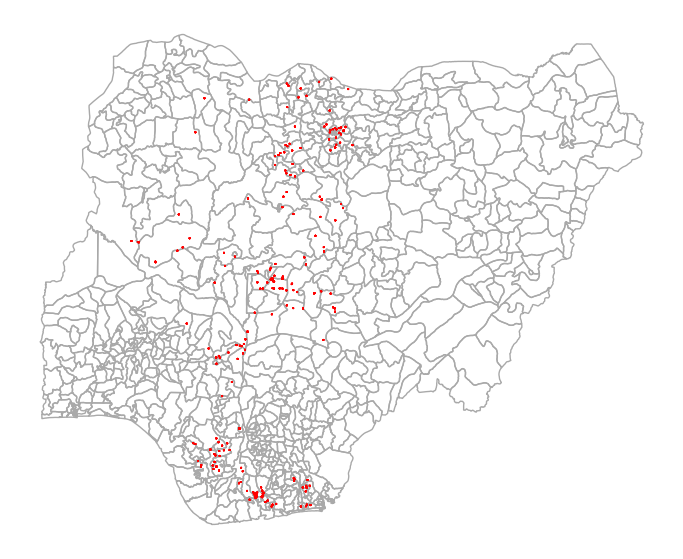

In [ ]:
#@title Plot household locations
nga_admin2 = gpd.read_file('geoBoundaries-NGA-ADM2.geojson')
geo_data = gpd.read_file('geo_data.geojson')
nga_admin2 = nga_admin2.to_crs(crs=geo_data.crs)

sns.set_style('white')
f, ax = plt.subplots(nrows=1, ncols=1, figsize=[18, 7])
ax.set_axis_off()

nga_admin2.plot(color='none', edgecolor='darkgray', ax=ax)
geo_data.plot(color='red', edgecolor='none', ax=ax)

# Supervised Learning Method


In [ ]:
#@title Helper Functions

def get_feat_importance(model_rf):
  feature_groups_dict = {
      'Population': ['tot_population'],
      'Built Up Environment': ['BUI_percentile_5', 'BUI_percentile_25','BUI_percentile_75','BUI_percentile_95', 'BUI_mean', 'BUI_median', 'BUI_prop', 'built_up_area'],
      'Urban/Rural Classification': ['urca_12', 'urca_9', 'urca_7', 'urca_10', 'urca_2', 'urca_5', 'urca_11', 'urca_3', 'urca_4', 'urca_13', 'urca_6', 'urca_16', 'urca_17', 'urca_19', 'urca_18'],
      'Electrification': ['electrification_prop_01', 'electrification_prop_02', 'electrification_prop_03', 'electrification_prop_04', 'electrification_prop_05', 'electrification_prop_06', 'electrification_prop_07', 'electrification_prop_08', 'electrification_prop_09', 'electrification_prop_10', 'electrification_prop_11', 'electrification_prop_12'],
      'Wealth': ['med_awi', 'med_spending'],
      'Weather': ['med_temperature','med_precipitation']
  }

  feature_importance_df = pd.DataFrame({
      'Feature': model_rf.feature_names_in_,
      'Importance': model_rf.feature_importances_
  }).sort_values(by='Importance', ascending=False)

  feature_importance_df['Group'] = feature_importance_df['Feature'].apply(lambda x: next((group_name for group_name, features in feature_groups_dict.items() if x in features), 'Other'))

  feature_importance_df['NormalizedImportanceScore'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()

  feature_importance_df_temp = feature_importance_df.groupby('Group').sum('NormalizedImportanceScore').reset_index().sort_values('NormalizedImportanceScore')

  fig = plt.figure(figsize = (10, 5))

  # creating the bar plot
  plt.barh(feature_importance_df_temp['Group'], feature_importance_df_temp['NormalizedImportanceScore'])

  plt.xlabel("Normalized Feature Importance Score")
  plt.title('Grouped Random Forest Feature Importance')
  plt.tight_layout()
  plt.show()

In [ ]:
# @title Apply PCA on the Appliances

# Read in appliance labels

pca_df = labels.pivot_table(index='hhid', columns='appliance', values='n_owned').reset_index()

 # check all appliances
app_subset = labels['appliance'].unique().tolist()

scaled_data = StandardScaler().fit_transform(pca_df[app_subset])
pca = PCA().fit(scaled_data)
pcs = pd.DataFrame(pca.transform(scaled_data)).rename({x: f'pc{x}' for x in range(pca.n_components_)}, axis=1)

pca_df = pca_df.assign(**{f'pc{i}': pcs[f'pc{i}'] for i in range(pca.n_components_)})
pca_df

appliance,hhid,Air conditioner,Air cooler,Electric cooker,Electric room heater,Electric water heater,Fan,Fridge,"Home mechanical appliances (e.g., Mixer, Blender)","Home thermal appliances (e.g., Kettle, Iron)",...,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,000a1b48-1223-4e6c-8d67-6a1c73f8b433,1.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,...,-0.781020,-1.539217,2.578273,-0.503241,0.418113,-0.101534,-0.160747,0.071875,0.323302,0.178815
1,00147ada-cbd4-4bc9-8b65-b07ec403cf7e,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,-0.438862,-0.052718,-0.222795,-0.424732,0.604092,-0.554040,-0.244602,-0.470703,-0.409032,-0.137572
2,00165d72-086b-4490-9d5d-82446d9a652f,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,...,0.310043,0.362830,0.235049,0.197235,-0.401054,0.803319,0.491269,1.027272,-0.103194,0.640757
3,002552a4-59d7-4244-bc7f-f749e056d442,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.138738,0.151189,0.137370,0.242013,-0.005728,-0.552344,0.338219,0.120145,0.142994,0.188701
4,00334d35-5375-4689-b39e-f000ec097d08,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,...,-1.278318,-1.267514,-0.936566,-1.159631,-0.798926,1.781365,2.138008,-0.572996,0.331619,-0.379890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,ffbf9d49-f7ea-41eb-a7b1-09322c7fde21,0.0,0.0,1.0,0.0,1.0,7.0,1.0,1.0,1.0,...,0.766748,-0.883587,3.556852,0.705590,1.529216,-1.589811,1.669455,-0.474913,0.172548,0.427089
3595,ffc5785f-8190-4472-ba5e-d9def9bf8e5a,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.621952,0.167934,-0.272078,-0.214195,-0.458528,1.005138,0.120027,0.947869,0.189348,-0.381306
3596,ffc68d42-78e2-4ed7-b518-96256bd75438,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.740071,-0.251553,-0.857212,-1.143631,0.417754,0.776975,-0.289234,0.303653,-0.622492,-0.746996
3597,ffe9dca6-2f06-4ec6-a854-592c7e0fcd9b,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.039823,0.033161,-0.294846,-0.149180,-0.061245,-0.323999,-0.009481,0.068971,0.594823,0.001878


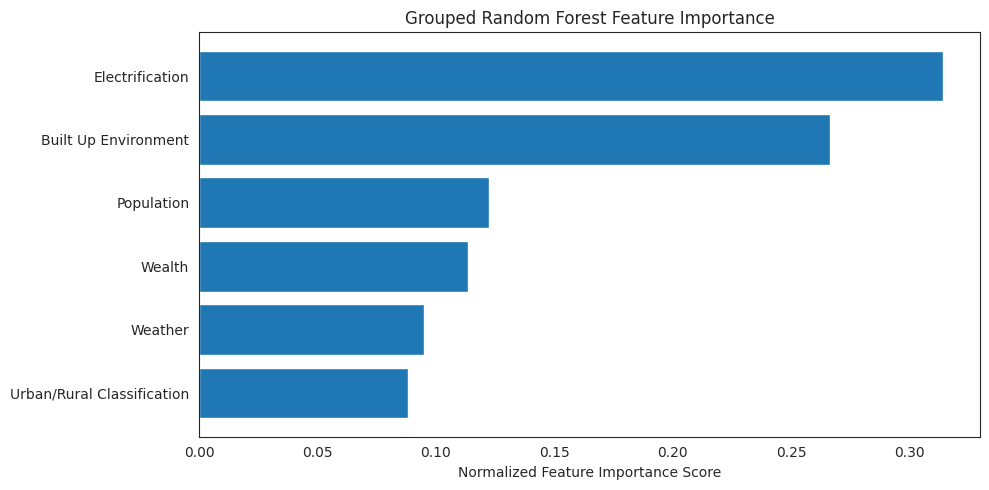

In [ ]:
#@title Build Random Forest Model

idx_pred_df = fts.merge(pca_df[['hhid', 'pc0', 'pc1']])

model_rf = RandomForestRegressor(random_state=123)
model_rf_1 = RandomForestRegressor(random_state=123)


# #Fit on entire dataset
train_fts = idx_pred_df.columns.drop(['hhid', 'geometry', 'pc0', 'pc1'])
model_rf.fit(idx_pred_df[train_fts], idx_pred_df['pc0'])
model_rf_1.fit(idx_pred_df[train_fts], idx_pred_df['pc1'])

get_feat_importance(model_rf)

In [ ]:
#Save model
import joblib
joblib.dump(model_rf, 'model_rf_pc0.pkl')

In [ ]:
#@title Apply Linear Model

# Dictionary to store appliance → trained model
app_to_model = {}
APPLIANCES = labels['appliance'].unique().tolist()
for app in APPLIANCES:
    lm = LinearRegression().fit(X=pca_df[['pc0', 'pc1']], y=pca_df[app])
    app_to_model[app] = lm

# Collect model metrics in a list of dictionaries
metrics_list = []
for app, model in app_to_model.items():
    metrics_list.append({
        'Appliance': app,
        'Coefficient0': model.coef_[0],
        'Coefficient1': model.coef_[1],
        'Intercept': model.intercept_
    })

# Create a Pandas DataFrame from the collected metrics
metrics_df = pd.DataFrame(metrics_list)

# Display the DataFrame
print("Linear Model Metrics:")
display(metrics_df)

Linear Model Metrics:


,Appliance,Coefficient0,Coefficient1,Intercept
0,Fan,0.681913,-0.583733,1.886079
1,Laptop / Computer,0.099374,0.086271,0.101139
2,Light bulb,1.361233,-1.136791,6.767435
3,Mobile phone charger,0.577571,-0.749008,2.480689
4,Radio,0.094019,-0.156088,0.400667
5,Television,0.314215,-0.228375,0.818839
6,Air cooler,0.006393,0.014712,0.006113
7,Fridge,0.152554,-0.019663,0.431787
8,Washing machine,0.047942,0.078852,0.040289
9,Air conditioner,0.058423,0.084458,0.057794


In [ ]:
#Save Linear Models
joblib.dump(app_to_model, 'linear_models_by_app.pkl')

In [ ]:
#@title Apply to country of Nigeria

# Read in features
df = gpd.read_file('lga_full_features.geojson')

df['pc0'] = model_rf.predict(df[train_fts])
df['pc1'] = model_rf_1.predict(df[train_fts])


# Loop through appliance models and make predictions
app_predictions = pd.DataFrame()
for app, model in app_to_model.items():
    # Make predictions using new data
    predictions = model.predict(df[['pc0', 'pc1']])  # new_data should be a DataFrame
    df[app] = predictions


df = df[['shapeName'] + list(APPLIANCES)]



In [ ]:
# Expansion

lga_num_hh = pd.read_csv('lga_num_hh.csv')

df_hh = df.merge(lga_num_hh, on='shapeName')

df_hh[APPLIANCES] = df_hh[APPLIANCES].multiply(df_hh['num_hh'], axis=0).round()

method1 = df_hh.copy()

# Unsupervised Learning Method

Insert some description here.

In [ ]:
# @title Helper Functions
def load_embeddings(df):
    """
    Loading the pandas dataframe
    :return: scaled data
    """
    df = df.drop(['hhid', 'geometry'], axis=1)

    # checking data shape
    row, col = df.shape
    print(f'There are {row} rows and {col} columns')
    # print(df.head(10))

    # to work on copy of the data
    df_scaled = df.copy()

    # Scaling the data to keep the different attributes in same range.
    scaler = StandardScaler()
    df_scaled[df_scaled.columns] = scaler.fit_transform(df_scaled)

    return df_scaled, scaler

def pca_embeddings(df_scaled, n_components):
    """To reduce the dimensions of the dataset we use Principal Component Analysis (PCA).
    :return: pca result, pca for plotting graph
    """
    pca_2 = PCA(n_components=n_components)
    pca_2_result = pca_2.fit_transform(df_scaled)
    n_components = len(pca_2.explained_variance_ratio_)

    print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
    print('Cumulative variance explained by '+str(n_components)+' principal components: {:.2%}'.format(
        np.sum(pca_2.explained_variance_ratio_)))


    # Results from pca.components_
    pc_labels = [f'PC_{i+1}' for i in range(n_components)]

    dataset_pca = pd.DataFrame(pca_2.components_, columns=df_scaled.columns, index=pc_labels)
    print('Results from pca.components')
    print('\n\n', dataset_pca)

    print("\n*************** Most important features *************************")
    for i, pc in enumerate(dataset_pca.index):
        # important_features = dataset_pca.loc[pc][dataset_pca.loc[pc] > 0.35]
        # print(f'\nAs per {pc}:\n', important_features.dropna())

        top_features = dataset_pca.loc[pc].abs().sort_values(ascending=False).head(3)

        # Retrieve the original signed values (not absolute)
        signed_top_features = dataset_pca.loc[pc][top_features.index]

        print(f'\nTop features for {pc}:')
        print(signed_top_features)
    print("\n******************************************************************")


    return pca_2_result, pca_2


def kmean_hyper_param_tuning(data):
    """
    Hyper parameter tuning to select the best from all the parameters on the basis of silhouette_score.
    :return: best number of clusters for the model (used for KMeans n_clusters)
    """
    # candidate values for our number of cluster
    parameters = [2, 3, 4, 5, 6]

    # instantiating ParameterGrid, pass number of clusters as input
    parameter_grid = ParameterGrid({'n_clusters': parameters})

    best_score = -1
    kmeans_model = KMeans(random_state=1)     # instantiating KMeans model
    silhouette_scores = []

    # evaluation based on silhouette_score
    for p in parameter_grid:
        kmeans_model.set_params(**p)    # set current hyper parameter
        kmeans_model.fit(data)          # fit model on dataset, this will find clusters based on parameter p

        ss = metrics.silhouette_score(data, kmeans_model.labels_)   # calculate silhouette_score
        silhouette_scores += [ss]       # store all the scores

        print('Parameter:', p, 'Score', ss)

        # check p which has the best score
        if ss > best_score:
            best_score = ss
            best_grid = p

    # plotting silhouette score
    plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    plt.xticks(range(len(silhouette_scores)), list(parameters))
    plt.title('Silhouette Score', fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.show()

    return best_grid['n_clusters']


def visualizing_results(pca_result, label, centroids_pca):
    """ Visualizing the clusters

    :param pca_result: PCA applied data
    :param label: K Means labels
    :param centroids_pca: PCA format K Means centroids
    """
    # ------------------ Using Matplotlib for plotting-----------------------
    x = pca_result[:, 0]
    y = pca_result[:, 1]

    scatter = plt.scatter(x, y, c=label, alpha=0.5, s=200)  # plot different colors per cluster

    for i, (cx, cy) in enumerate(centroids_pca):
        plt.text(cx, cy, f"{cx:.2f}, {cy:.2f}", fontsize=9, ha='left', va='center', color='white')


    plt.title('Household clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black")#, lw=1.5)

    unique_labels = np.unique(label)
    colors = scatter.cmap(scatter.norm(unique_labels))
    legend_handles = [
        Patch(color=colors[i], label=f"{i}") for i in unique_labels
    ]
    plt.legend(handles=legend_handles, title="Clusters")
    plt.show()


### Load Data

In [ ]:
# For enterprise data

df = gpd.read_file("nigeria_reduced_features.geojson")

print("1. Scaling Appliance Dataset\n")
data_scaled, scaler= load_embeddings(df)

data_scaled.head(1)

1. Scaling Appliance Dataset

There are 3599 rows and 13 columns


,tot_population,med_temperature,med_precipitation,med_awi,med_spending,BUI_percentile_25,BUI_median,BUI_percentile_75,built_up_area,urban,periurban,rural,electrification_prop_mean
0,-0.904671,1.775,-0.727132,-0.760095,-0.364995,-0.156452,-0.303926,-0.63433,-0.62202,-0.514876,0.780763,-0.460944,-0.438819


### PCA

In [ ]:
print("\n\n2. Reducing via PCA\n")
n_components = 2
pca_result, pca_2 = pca_embeddings(data_scaled, n_components)



2. Reducing via PCA

Explained variation per principal component: [0.47929709 0.14017711]
Cumulative variance explained by 2 principal components: 61.95%
Results from pca.components


       tot_population  med_temperature  med_precipitation   med_awi  \
PC_1        0.290453        -0.022595           0.207177  0.328388   
PC_2       -0.259487        -0.061534           0.222917  0.040908   

      med_spending  BUI_percentile_25  BUI_median  BUI_percentile_75  \
PC_1      0.343055           0.221383    0.301978            0.36453   
PC_2      0.085888           0.286903    0.286037            0.04919   

      built_up_area     urban  periurban     rural  electrification_prop_mean  
PC_1       0.380979  0.215681  -0.194456  0.031312                   0.378337  
PC_2       0.008348 -0.247707   0.614955 -0.513739                   0.007894  

*************** Most important features *************************

Top features for PC_1:
built_up_area                0.380979
electrification_

### Fitting KMeans



4. Visualizing the data


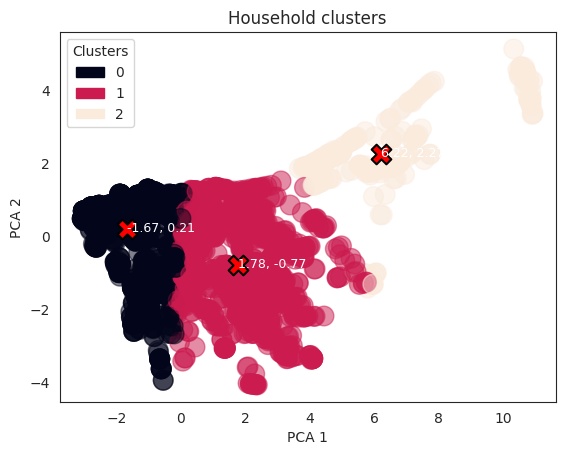

In [ ]:
# Fitting KMeans
optimum_num_clusters = 3
kmeans = KMeans(n_clusters=optimum_num_clusters, random_state=42)
kmeans.fit(data_scaled)
centroids = kmeans.cluster_centers_
centroids_pca = pca_2.transform(centroids)

#Order the centroids to keep track of correspondence
order = np.argsort(centroids_pca[:, 0])
label_map = {old_label: new_label for new_label, old_label in enumerate(order)}

# Re-assign labels according to the sorted order
labels_mapped = np.vectorize(label_map.get)(kmeans.labels_)

# Now visualize with labels_mapped
print("\n\n4. Visualizing the data")
visualizing_results(pca_result, labels_mapped, centroids_pca[order])

In [ ]:
# Add labels to scaled data for visualization
drop_cols = ['hhid', 'geometry']
X_scaled = scaler.fit_transform(df.drop(drop_cols, axis=1))

hh_w_labels = pd.DataFrame(X_scaled, columns=df.drop(drop_cols, axis=1).columns)
hh_w_labels['cluster'] = labels_mapped

cluster_profiles = hh_w_labels.groupby('cluster').median()


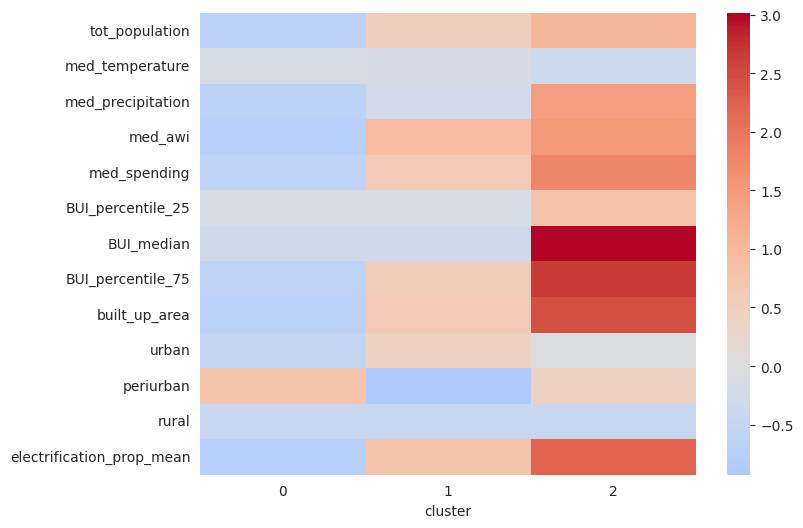

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_profiles.T, cmap="coolwarm", center=0)
plt.show()

In [ ]:
for col in df[[col for col in df.columns if col.startswith('BUI')]].columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [ ]:
# Add labels to unscaled data for interpretation

df['cluster'] = labels_mapped

display(df.drop(drop_cols, axis=1).groupby('cluster').median())
display(df.drop(drop_cols, axis=1).groupby('cluster').mean())
display(df.drop(drop_cols, axis=1).groupby('cluster').agg([min, max]))


,tot_population,med_temperature,med_precipitation,med_awi,med_spending,BUI_percentile_25,BUI_median,BUI_percentile_75,built_up_area,urban,periurban,rural,electrification_prop_mean
cluster,,,,,,,,,,,,,
0,12023.462891,299.959625,0.001927,0.273437,2.562880,0.000000,0.000000,0.000000,1.115577,0.000000,100.000000,0.0,0.098555
1,34175.214844,299.875641,0.003007,0.970410,3.409132,0.000000,0.000000,0.265247,4.100236,14.285714,66.666667,0.0,0.451638
2,44608.781250,299.699493,0.007304,1.218174,4.167683,0.043443,0.372112,0.741321,8.202426,7.142857,92.857143,0.0,0.803312


,tot_population,med_temperature,med_precipitation,med_awi,med_spending,BUI_percentile_25,BUI_median,BUI_percentile_75,built_up_area,urban,periurban,rural,electrification_prop_mean
cluster,,,,,,,,,,,,,
0,13932.259532,300.110971,0.002740,0.323398,2.567271,0.000000,0.000000,0.010309,1.250450,0.965296,92.752939,6.281765,0.117555
1,39329.836061,300.113474,0.004624,0.923443,3.441532,0.000573,0.024418,0.264995,4.119869,18.804523,70.671675,10.523801,0.454905
2,45536.895286,299.721212,0.006967,1.222866,4.323972,0.114740,0.420002,0.748631,8.528420,13.434482,86.288462,0.277056,0.814445


tot_population                med_temperature              \
                   min            max             min         max   
cluster                                                             
0          1292.328857   62836.621094      297.451508  302.596161   
1          8781.324219  123524.343750      298.294952  302.096527   
2         27377.597656   68492.171875      299.458130  300.159241   

        med_precipitation             med_awi           med_spending  \
                      min       max       min       max          min   
cluster                                                                
0                0.000865  0.009198 -0.194680  1.117770     1.548886   
1                0.001076  0.009720  0.201337  1.323969     2.452847   
2                0.001094  0.007608  1.118079  1.311753     3.638545   

                   ... built_up_area            urban             periurban  \
              max  ...           min        max   min        max        min   
cluster            ...                                                        
0        3.758595  ...      0.191283   3.872487   0.0  33.333333  30.769231   
1        5.951539  ...      1.633453   7.983010   0.0  66.666667  25.000000   
2        5.103525  ...      5.679713  11.579687   0.0  66.666667  33.333333   

               rural            electrification_prop_mean            
           max   min        max                       min       max  
cluster                                                              
0        100.0   0.0  69.230769                  0.000000  0.462667  
1        100.0   0.0  75.000000                  0.178527  0.852422  
2        100.0   0.0   7.142857                  0.659213  0.975503  

[3 rows x 26 columns]

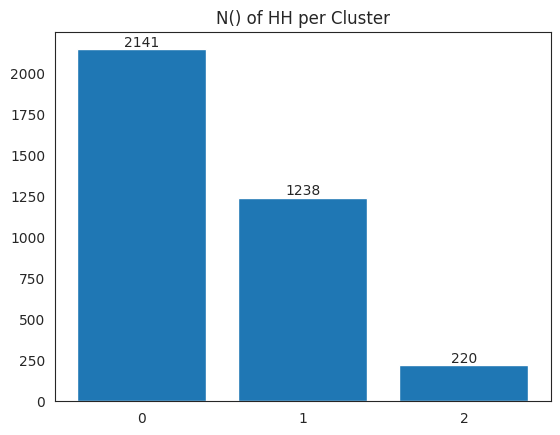

In [ ]:
counts = df['cluster'].value_counts()

plt.bar(counts.index, counts.values)
plt.xticks(ticks=counts.index, labels=counts.index.astype(int))
plt.title('N() of HH per Cluster')
for i in range(3):
    plt.text(i, counts.values[i], str(counts.values[i]), ha='center', va='bottom')
plt.show()


### Map clusters

In [ ]:
#Add appliances to df if not already included

df = df.merge(labels_t, on='hhid')

hh_clusters = df.groupby('cluster')[APPLIANCES].mean().reset_index()

### Apply to country of Nigeria

In [ ]:
# Map country wide feature PCA to cluster centroids
# Multiply with number of households

lga_features = gpd.read_file('lga_features.geojson')


# Using predict() to assign clusters

lga_features['cluster'] = kmeans.predict(lga_features[data_scaled.columns.to_list()])
lga_cluster = lga_features[['shapeName', 'cluster']]


lga_num_hh = pd.read_csv('lga_num_hh.csv')
lga_hh_cluster = lga_cluster.merge(lga_num_hh, on='shapeName')


In [ ]:
# Merge cluster key with main df
lga_hh_cluster_app = lga_hh_cluster.merge(hh_clusters, on='cluster')

APPLIANCES = hh_clusters.columns[1:]

#Multiply num_hh with each appliance count
lga_hh_cluster_app[APPLIANCES] = lga_hh_cluster_app[APPLIANCES].multiply(lga_hh_cluster_app['num_hh'], axis=0).round()

method2 = lga_hh_cluster_app.copy()

# Evaluate Results

compare the supervised/unsupervised methods

In [ ]:

diff = method1.drop(columns=['shapeName', 'num_hh']) - method2.drop(columns=['shapeName', 'cluster', 'num_hh'])

diff['shapeName'] = method2['shapeName']


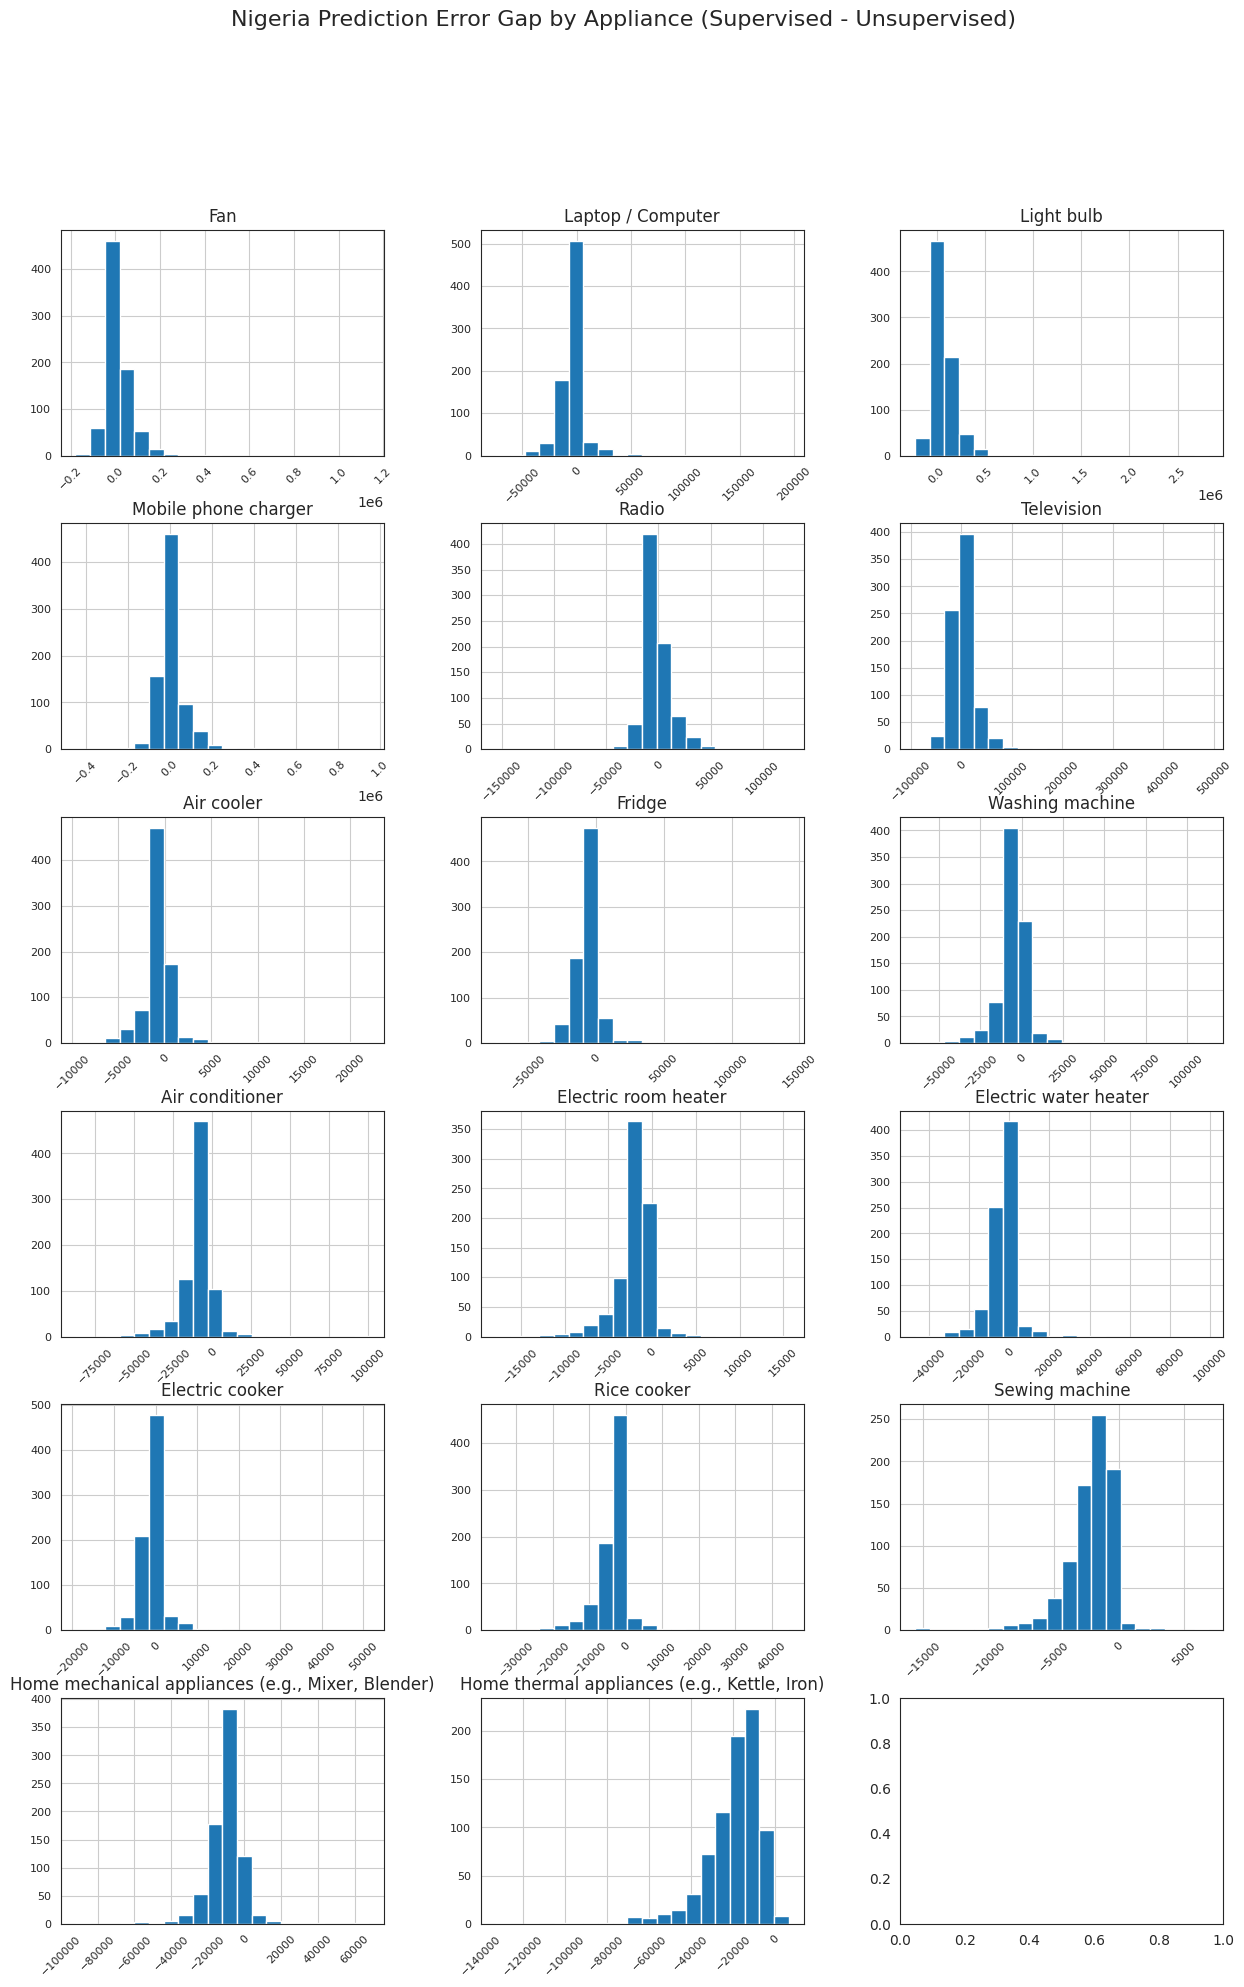

In [ ]:

fig, axes = plt.subplots(6, 3, figsize=(15, 22))
axes = axes.flatten()

for i, app in enumerate(APPLIANCES):
    diff[[app]].hist(ax=axes[i], bins=20)
    axes[i].set_title(app)
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].tick_params(axis='both', labelsize=8)

fig.suptitle("Nigeria Prediction Error Gap by Appliance (Supervised - Unsupervised)", fontsize=16)

plt.show()



In [ ]:
#Correlation
correlations = {
    col: method1.drop(columns=['shapeName'])[col].corr(method2.drop(columns=['shapeName'])[col])
    for col in method1.drop(columns=['shapeName']).columns
}

cor_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])

print(cor_df)



                                                   correlation
Fan                                                   0.906455
Laptop / Computer                                     0.802679
Light bulb                                            0.959795
Mobile phone charger                                  0.898722
Radio                                                 0.836657
Television                                            0.917743
Air cooler                                            0.665455
Fridge                                                0.954258
Washing machine                                       0.707281
Air conditioner                                       0.738542
Electric room heater                                  0.660487
Electric water heater                                 0.776616
Electric cooker                                       0.861659
Rice cooker                                           0.680788
Sewing machine                                        0